In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [14]:
import torch
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
import time
import csv
import sys
import os
import pandas as pd
from collections import Counter
import seaborn as sn
from sklearn.metrics import confusion_matrix
import cv2
import math
# sys.path.insert(1, '../../util')
sys.path.insert(1, '/content/drive/MyDrive/VC/VCPI_Project/')
import vcpi_util

print(torch.__version__)

2.2.1+cu121


# Load data

In [15]:
# Definindo o dispositivo para treinamento
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

# Configurações do treinamento
BATCH_SIZE = 50
# IMG_SIZE = 128
HEIGHT = 64
WIDTH = 64
EPOCHS = 30
#SAMPLES = 00042

PATH_TEST_SET = '/content/drive/MyDrive/VC/VCPI_Project/data/test_images'
PATH_TRAINING_SET = '/content/drive/MyDrive/VC/VCPI_Project/data/train_images/GTSRB/Final_Training/Images'

# class_paths = {}
# for c in range(43):
#     # Construct the directory path for the current class
#     class_directory = os.path.join(PATH_TRAINING_SET, f"{c:05d}")
#     # Check if the directory exists
#     if os.path.isdir(class_directory):
#         # Store the path in the dictionary
#         class_paths[f"class_{c:05d}_path"] = class_directory


print(f'PATH_TRAINING_SET: {PATH_TRAINING_SET}')
print(f'PATH_TEST_SET: {PATH_TEST_SET}')

cpu
PATH_TRAINING_SET: /content/drive/MyDrive/VC/VCPI_Project/data/train_images/GTSRB/Final_Training/Images
PATH_TEST_SET: /content/drive/MyDrive/VC/VCPI_Project/data/test_images


In [16]:
# Definição das transformações
transform = transforms.Compose([
    transforms.Resize((HEIGHT, WIDTH)),  # Redimensionar as imagens
    transforms.ToTensor(),        # Converter as imagens para tensores
])

# Carregamento dos conjuntos de treinamento e teste

train_set = torchvision.datasets.ImageFolder(root=PATH_TRAINING_SET, transform=transform)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True)

test_set = torchvision.datasets.MNIST(root=PATH_TEST_SET, train=False, download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=False)

In [17]:
# For the training set
train_images, train_targets = next(iter(train_loader))
print("Training Set:")
print("Batch shape:", train_images.shape)
print(f"Targets: {train_targets}")
print("Training set samples:", len(train_loader.dataset))
print("Training set batches:", len(train_loader))

Training Set:
Batch shape: torch.Size([50, 3, 64, 64])
Targets: tensor([ 2, 13,  3,  1, 25, 29, 18, 13, 25, 38, 10, 10, 40,  2,  5, 38, 14, 38,
         5, 15,  2, 33,  9, 35, 30,  4, 38, 17, 18,  2, 38,  8,  1,  9, 22, 11,
         2, 17,  1,  1,  7, 13, 14, 12, 11,  8, 10, 11, 26, 12])
Training set samples: 39226
Training set batches: 785


In [18]:
# For the test set
test_images, test_targets = next(iter(test_loader))
print("\nTest Set:")
print("Batch shape:", test_images.shape)
img_np = test_images.numpy()
print("Each image varies between", np.min(img_np), "and", np.max(img_np))
# Putting color channel last so that the image can be displayed
img_np = np.transpose(img_np, (0, 2, 3, 1))
print("Shape after channel transpose:", img_np.shape)
print("Test set samples:", len(test_loader.dataset))
print("Test set batches:", len(test_loader))


Test Set:
Batch shape: torch.Size([50, 1, 64, 64])
Each image varies between 0.0 and 1.0
Shape after channel transpose: (50, 64, 64, 1)
Test set samples: 10000
Test set batches: 200


# Marosca para as informações de cada imagem

In [105]:
csv_directory = '/content/drive/MyDrive/VC/VCPI_Project/data/train_images/GTSRB/Final_Training/Images'

image_info_by_class = {}

# Iterar sobre os subdiretórios
for subdir in os.listdir(csv_directory):
    subdir_path = os.path.join(csv_directory, subdir)
    if os.path.isdir(subdir_path):
        # Iterar sobre os arquivos CSV em cada subdiretório
        for filename in os.listdir(subdir_path):
            if filename.endswith('.csv'):
                csv_path = os.path.join(subdir_path, filename)

                # Verificar se o arquivo CSV está vazio ou não
                if os.path.getsize(csv_path) == 0:
                    print(f'O arquivo CSV {csv_path} está vazio.')
                    continue

                # Abrir o arquivo CSV e ler as informações das imagens
                with open(csv_path, 'r') as csvfile:
                    next(csvfile)  # Ignorar a primeira linha de cabeçalho
                    for line in csvfile:
                        # Dividir a linha usando o ponto e vírgula como delimitador
                        row = line.strip().split(';')

                        # Verificar se a linha contém informações suficientes
                        if len(row) < 8:
                            print(f'A linha do arquivo CSV {csv_path} não possui informações suficientes.')
                            continue

                        # Extrair informações da linha
                        image_filename = row[0]  # Nome do arquivo de imagem
                        class_id = row[7]  # ID da classe

                        # Criar um dicionário para armazenar as informações da imagem
                        image_info = {
                            'Filename': row[0],
                            'Width': row[1],
                            'Height': row[2],
                            'Roi.X1': row[3],
                            'Roi.Y1': row[4],
                            'Roi.X2': row[5],
                            'Roi.Y2': row[6],
                            'ClassId': row[7]
                        }

                        # Adicionar as informações da imagem ao dicionário correspondente à classe
                        class_dict_key = f'GT-{class_id.zfill(5)}'
                        if class_dict_key not in image_info_by_class:
                            image_info_by_class[class_dict_key] = {}
                        image_info_by_class[class_dict_key][image_filename] = image_info

In [106]:
# Exemplo de como acessar as informações de uma imagem específica de uma classe específica
class_id = '00042'
image_filename = '00000_00000.ppm'
class_dict_key = f'GT-{class_id.zfill(5)}'
image_info = image_info_by_class.get(class_dict_key, {}).get(image_filename)
if image_info:
    print(f'Informações da imagem {image_filename} da classe {class_id}: {image_info}')
else:
    print(f'As informações da imagem {image_filename} da classe {class_id} não foram encontradas.')

Informações da imagem 00000_00000.ppm da classe 00042: {'Filename': '00000_00000.ppm', 'Width': '27', 'Height': '28', 'Roi.X1': '5', 'Roi.Y1': '6', 'Roi.X2': '22', 'Roi.Y2': '23', 'ClassId': '42'}


# Display batch of images

In [20]:
new_class_names = ['0' if class_name == '00000' else class_name.replace('0', '') for class_name in train_set.classes]
train_set.classes = new_class_names

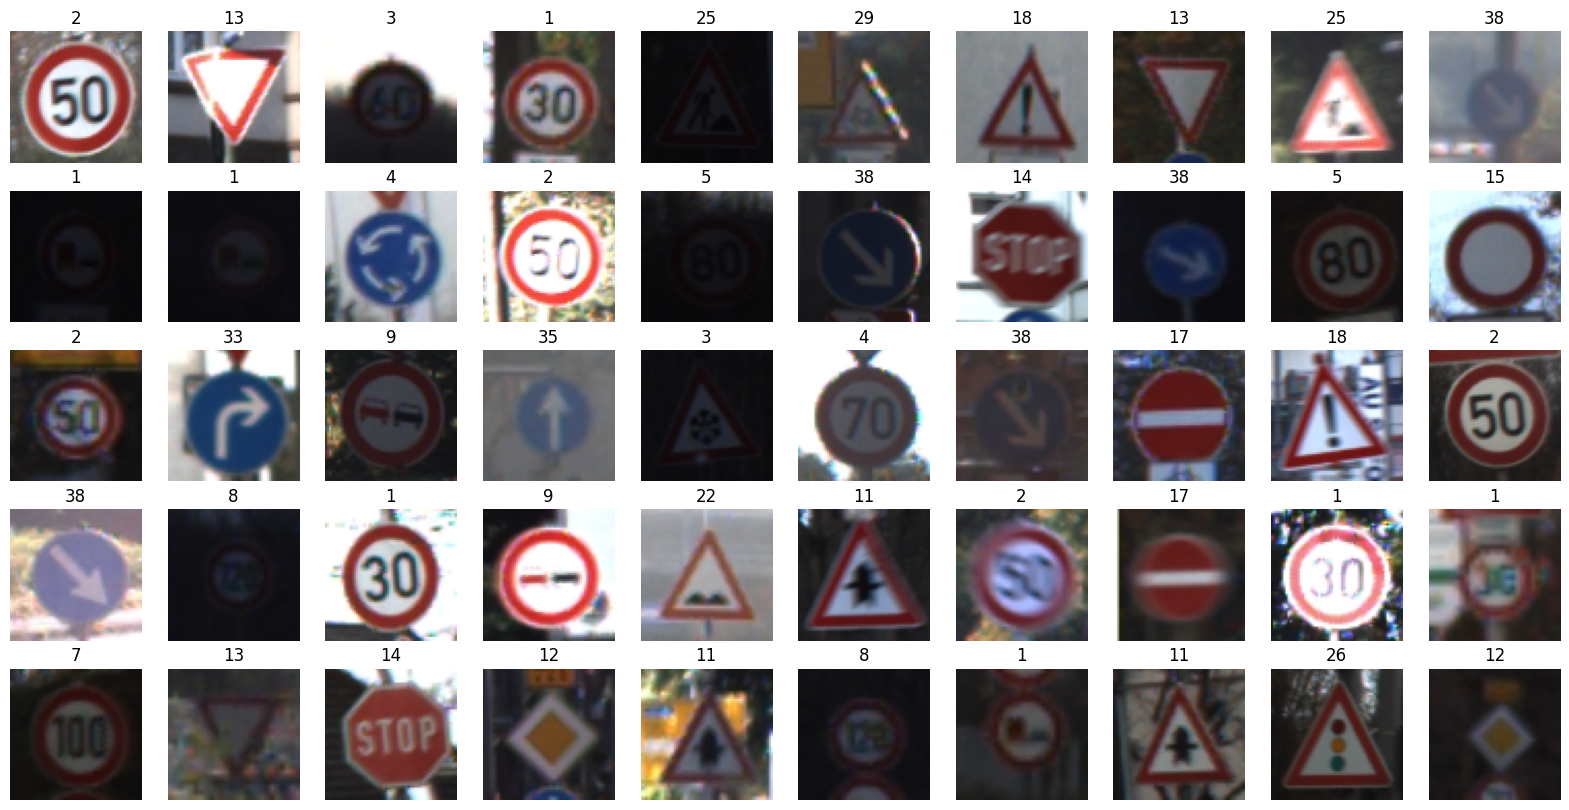

<Figure size 640x480 with 0 Axes>

In [21]:
vcpi_util.show_images(5,10, train_images, train_targets, train_set.classes)

Counter({2: 5, 38: 5, 1: 4, 13: 3, 10: 3, 11: 3, 25: 2, 18: 2, 5: 2, 14: 2, 9: 2, 17: 2, 8: 2, 12: 2, 3: 1, 29: 1, 40: 1, 15: 1, 33: 1, 35: 1, 30: 1, 4: 1, 22: 1, 7: 1, 26: 1})


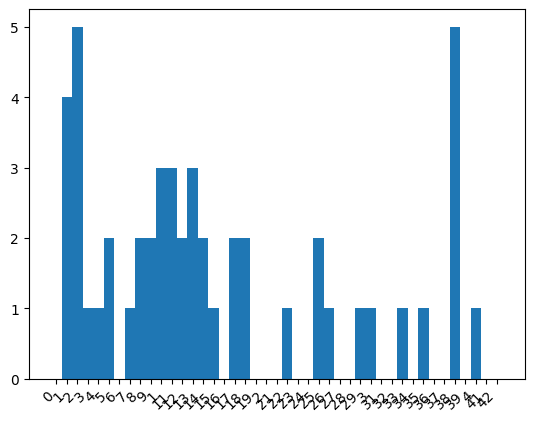

In [22]:
vcpi_util.show_histogram(train_targets, train_set.classes)

In [23]:
# Função para mostrar o histograma de uma imagem
def show_image_histogram(image, ax, image_name):
    ax.hist(image.flatten(), bins=50, color='c')
    ax.set_xlabel('Pixel Value')
    ax.set_ylabel('Frequency')
    ax.set_title(image_name)

In [24]:
# Verificar normalização dos valores das imagens [0.0, 1.0]
print("Valor mínimo train_images:", torch.min(train_images))
print("Valor máximo train_images:", torch.max(train_images))
print()
print("Valor mínimo test_images:", torch.min(test_images))
print("Valor máximo test_images:", torch.max(test_images))

Valor mínimo train_images: tensor(0.)
Valor máximo train_images: tensor(1.)

Valor mínimo test_images: tensor(0.)
Valor máximo test_images: tensor(1.)


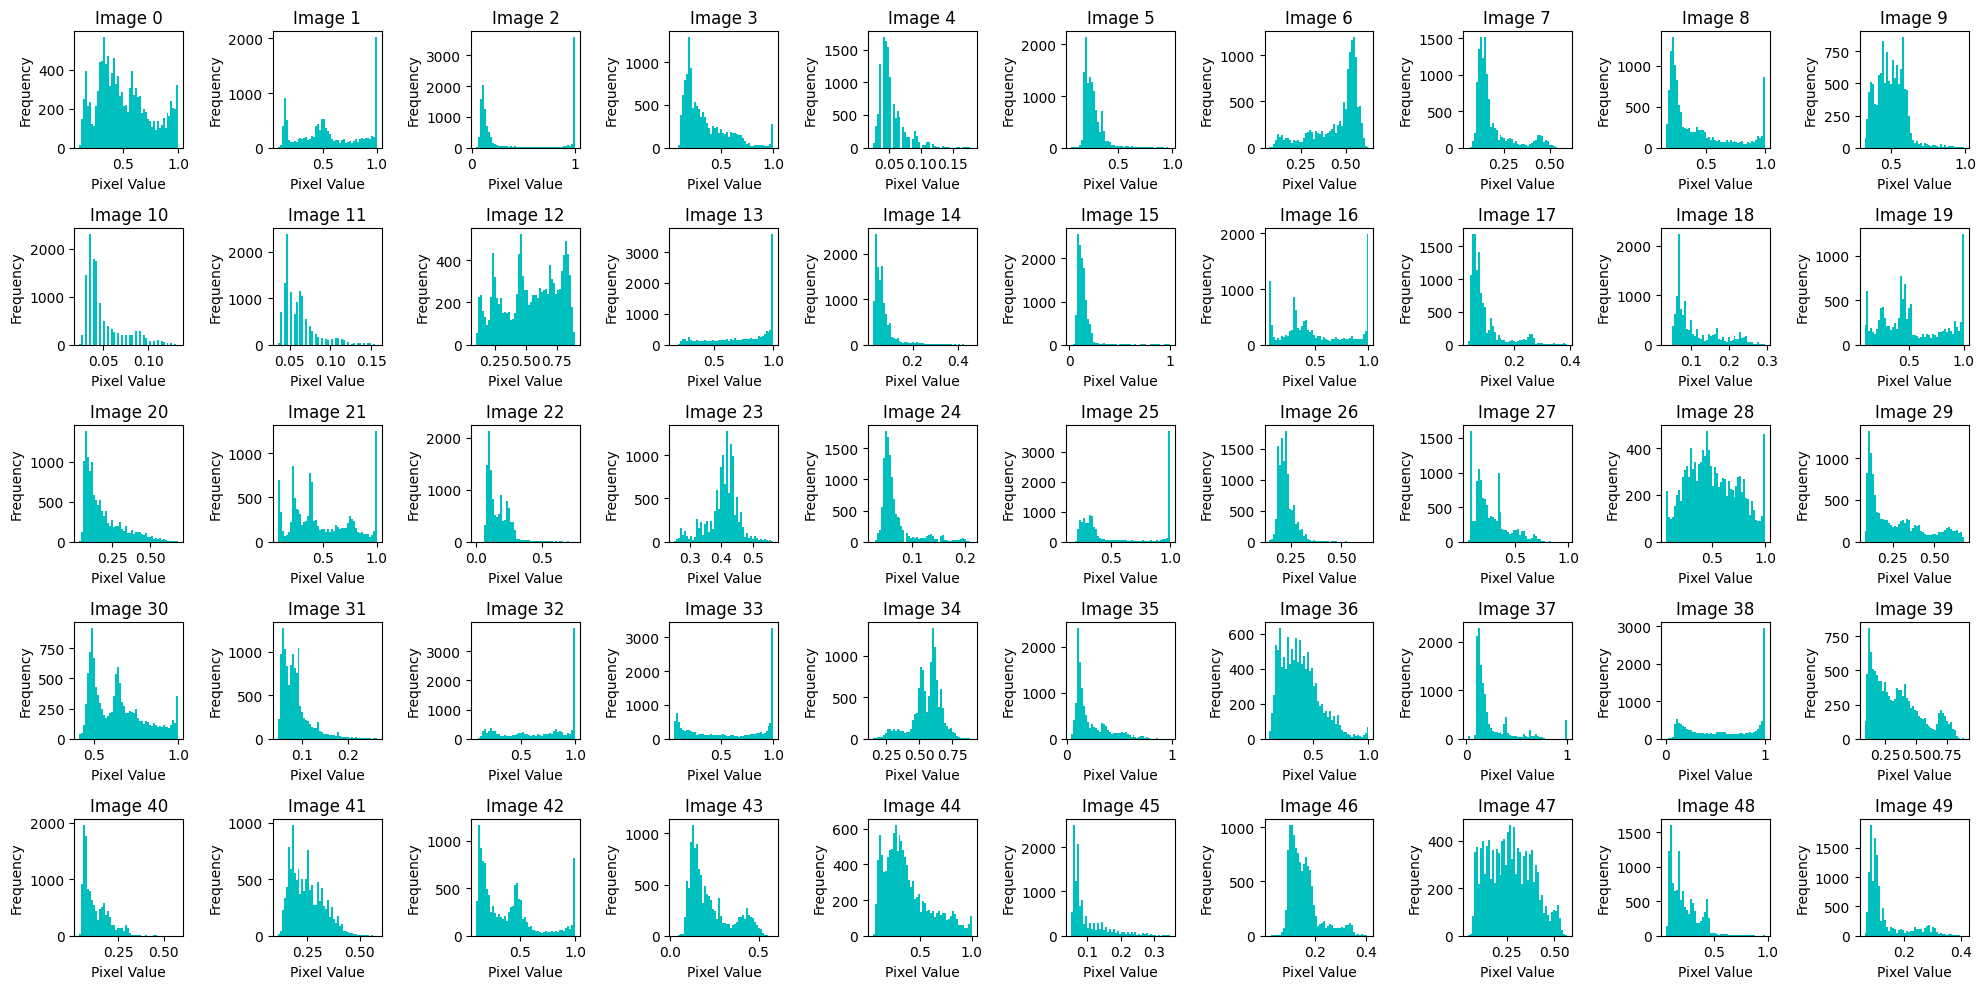

In [25]:
rows = 5
cols = 10
fig, axes = plt.subplots(rows, cols, figsize=(20, 10))

imagesHist, _ = train_images, train_targets
for i, image in enumerate(imagesHist):
    # Calcular as coordenadas da subplot
    row = i // cols
    col = i % cols
    # Mostrar o histograma da imagem atual na subplot correspondente
    show_image_histogram(image, axes[row, col], f'Image {i}')
    # Parar o loop quando atingirmos o número total de subplots
    if i == rows * cols - 1:
        break

plt.tight_layout()
plt.show()

Equalização do histograma de frequências

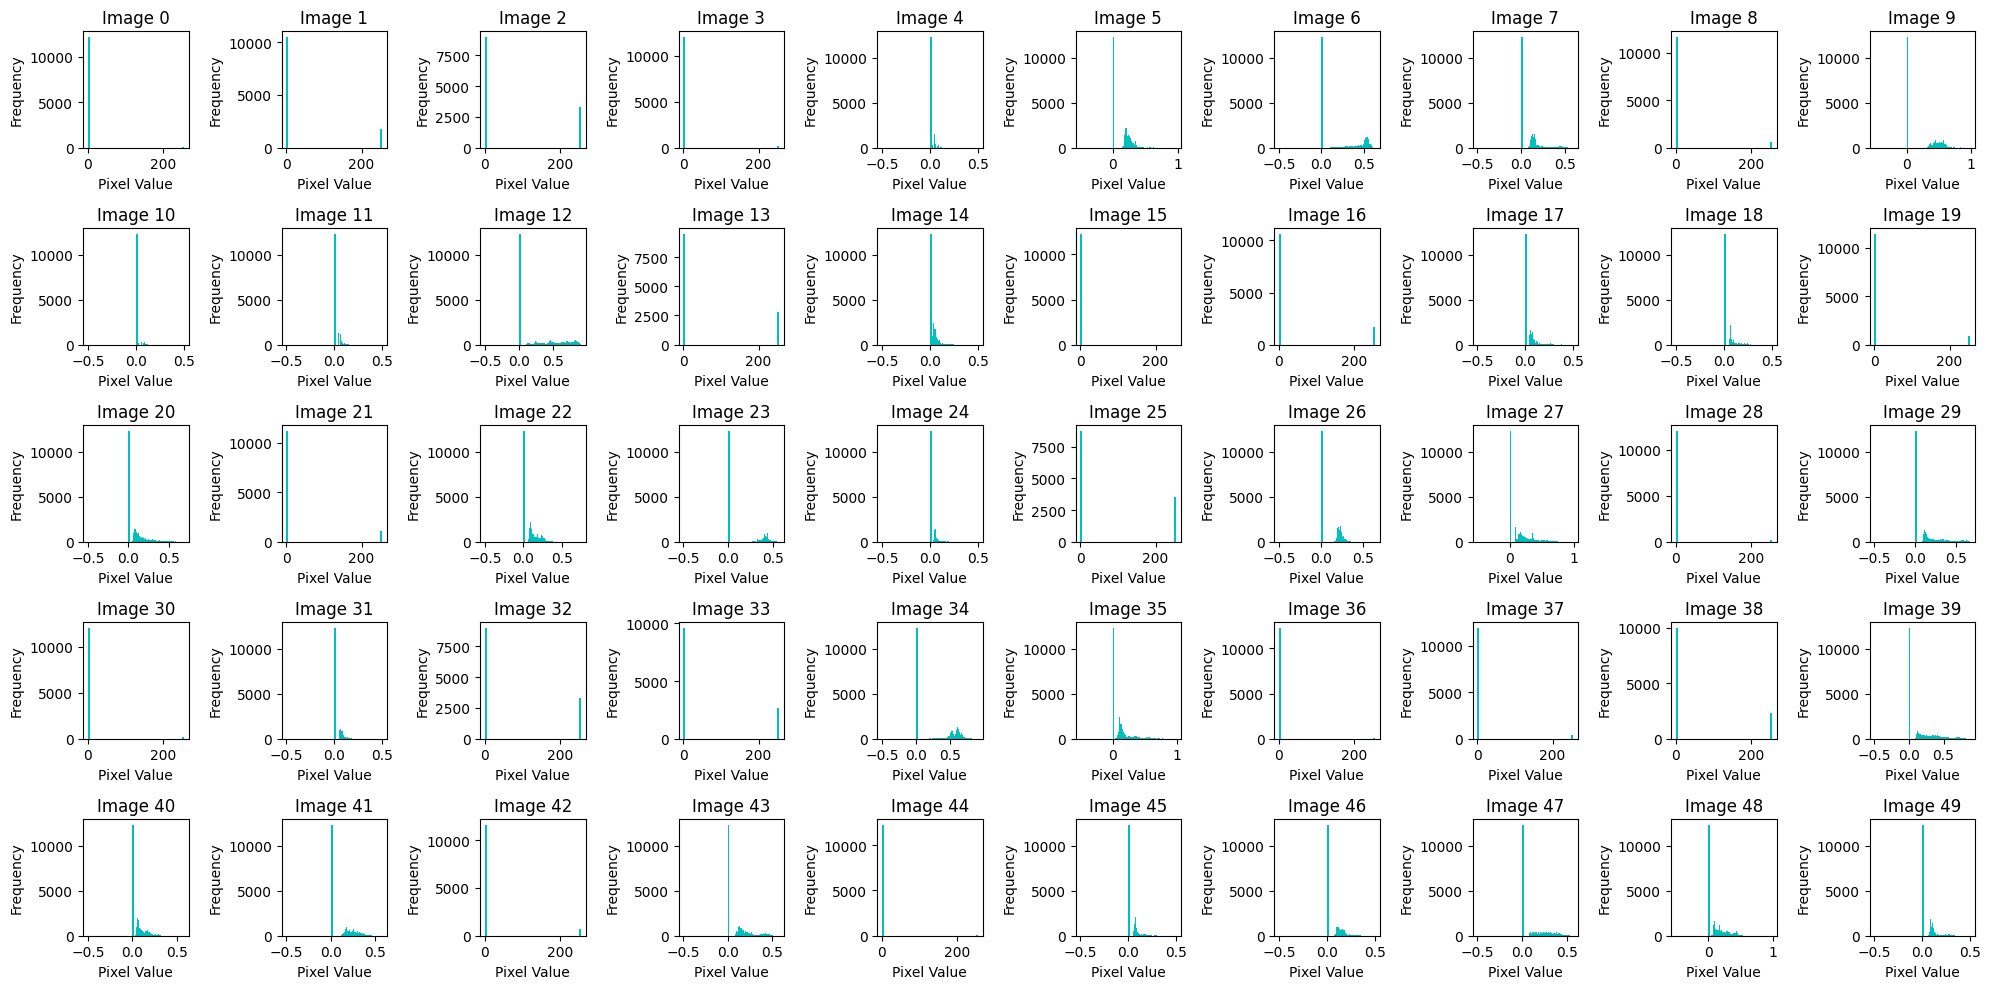

In [26]:
# Função para equalizar o histograma de uma imagem usando OpenCV
def equalize_image_histogram_cv2(image):
    # Assuming the image is a stack of grayscale images
    # Convert each channel to a grayscale image and equalize its histogram
    equalized_channels = []
    for channel in range(image.shape[0]):
        channel_image = image[channel, :, :]
        channel_image = channel_image.astype('uint8')
        equalized_channel = cv2.equalizeHist(channel_image)
        equalized_channels.append(equalized_channel)

    # Combine the equalized channels back into a single image
    equalized_image = np.stack(equalized_channels, axis=0)
    return equalized_image

rows = 5
cols = 10
fig, axes = plt.subplots(rows, cols, figsize=(20, 10))

imagesHist, _ = train_images, train_targets
equalized_imgs = []
for i, image in enumerate(imagesHist):
    # Calcular as coordenadas da subplot
    row = i // cols
    col = i % cols
    # Equalizar o histograma da imagem atual usando OpenCV
    equalized_image_cv2 = equalize_image_histogram_cv2(image.numpy())
    equalized_imgs.append(equalized_image_cv2)
    # Mostrar o histograma da imagem equalizada na subplot correspondente
    show_image_histogram(equalized_image_cv2, axes[row, col], f'Image {i}')
    # Parar o loop quando atingirmos o número total de subplots
    if i == rows * cols - 1:
        break

for i, image in enumerate(imagesHist):
    # Calcular as coordenadas da subplot
    row = i // cols
    col = i % cols
    if isinstance(image, torch.Tensor):
        image_np = image.numpy()
    else:
        image_np = image
    show_image_histogram(image_np, axes[row, col], f'Image {i}')
    # Parar o loop quando atingirmos o número total de subplots
    if i == rows * cols - 1:
        break

plt.tight_layout()
plt.show()

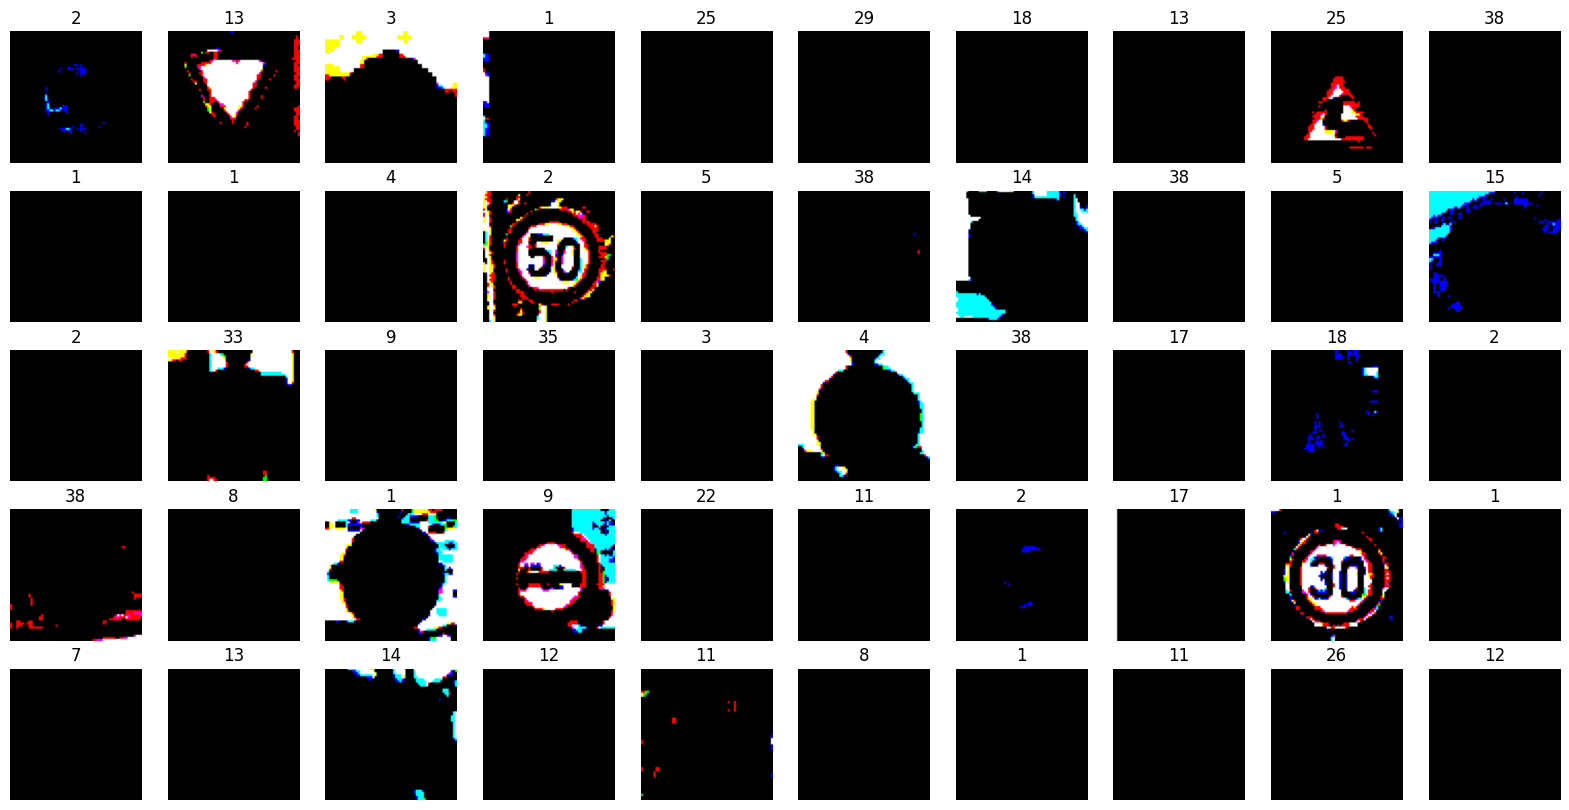

<Figure size 640x480 with 0 Axes>

In [27]:
equalized_imgs_numpy = np.stack(equalized_imgs)
equalized_imgs_tensor = torch.tensor(equalized_imgs_numpy)

vcpi_util.show_images(5,10, equalized_imgs_tensor, train_targets, train_set.classes)

Aplicação do filtro 'medianBlur' - remoção de ruído (nao estou a conseguir :( )

Formato da imagem antes da conversão: (64, 64, 3)
Formato da imagem após a conversão: (64, 64, 3)
A conversão para escala de cinza falhou.


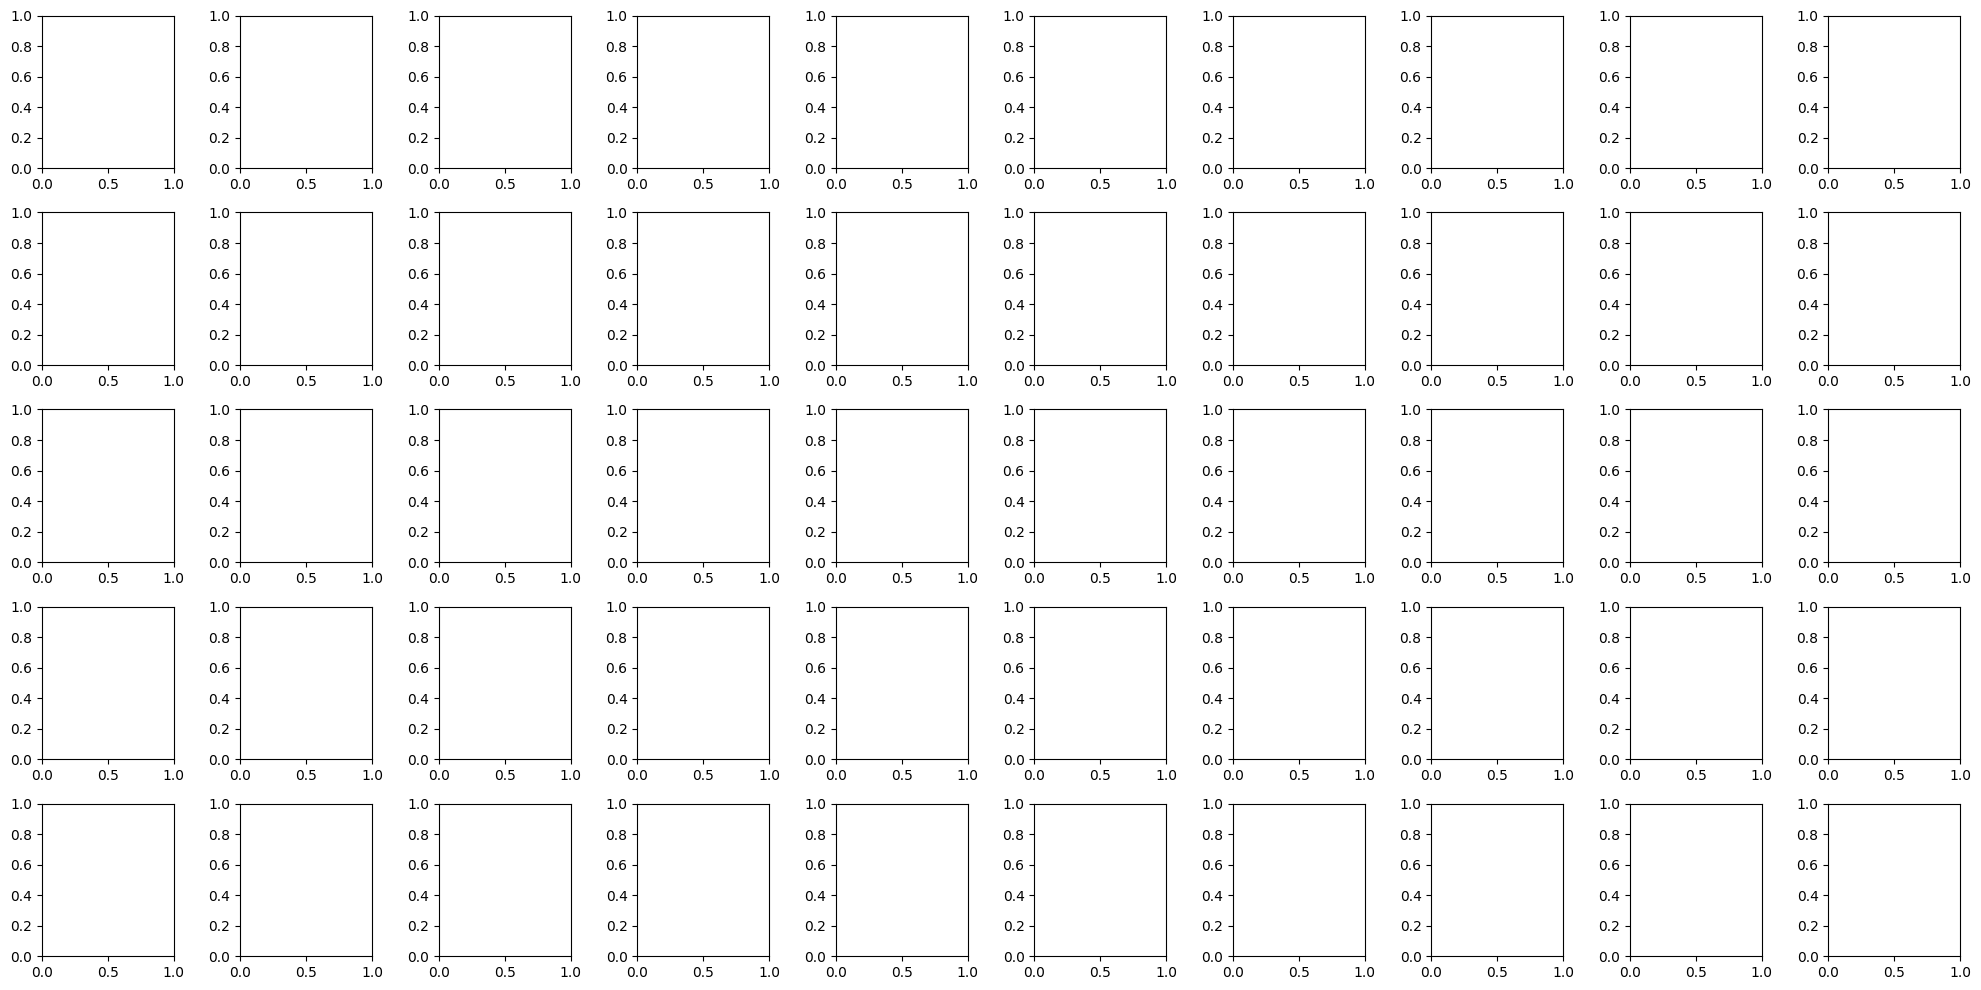

In [79]:
def show_images(rows, cols, images, targets, classes):
    fig, axes = plt.subplots(rows, cols, figsize=(20, 10))
    for a in range(len(images)):
        image = images[a].numpy() if torch.is_tensor(images[a]) else images[a]
        image = np.transpose(image, (1, 2, 0))
        image = (image * 255).astype(np.uint8)

        if image.shape[2] == 3 and image.dtype == np.uint8:
          print("Formato da imagem antes da conversão:", image.shape)
          try:
              image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
              print("Formato da imagem após a conversão:", image.shape)
              if len(image.shape) == 2:
                  print("A imagem foi convertida com sucesso para escala de cinza.")
              else:
                  print("A conversão para escala de cinza falhou.")
              break
          except Exception as e:
              print(e)
              continue

        # Aplicar o desfoque de mediana a cada canal de cor separadamente
        smooth_channels = []
        print(f'image.shape (deve ser cinza): {image.shape}')
        if image.shape[2] == 1:
          print(f'imagem cinza!!!!')
          for channel in range(image.shape[2]): # Ajustado para iterar sobre os canais de cor
              channel_image = image[:, :, channel]
              channel_image = cv2.medianBlur(channel_image, 7, 0)
              smooth_channels.append(channel_image)

        # Combine os canais de volta em uma imagem RGB
        smooth_image_rgb = np.stack(smooth_channels, axis=2) # Ajustado para empilhar os canais de cor
        smooth_image_rgb = cv2.cvtColor(smooth_image_rgb, cv2.COLOR_BGR2RGB) # Converter de volta para RGB

        target = targets[a]
        subplot_title = classes[target]
        axes.ravel()[a].set_title(subplot_title)
        axes.ravel()[a].imshow(smooth_image_rgb)
        axes.ravel()[a].axis('off')
    fig.tight_layout()
    plt.show()

show_images(5, 10, train_images, train_targets, train_set.classes)

Transformar as imagens em formato binário (threshold)

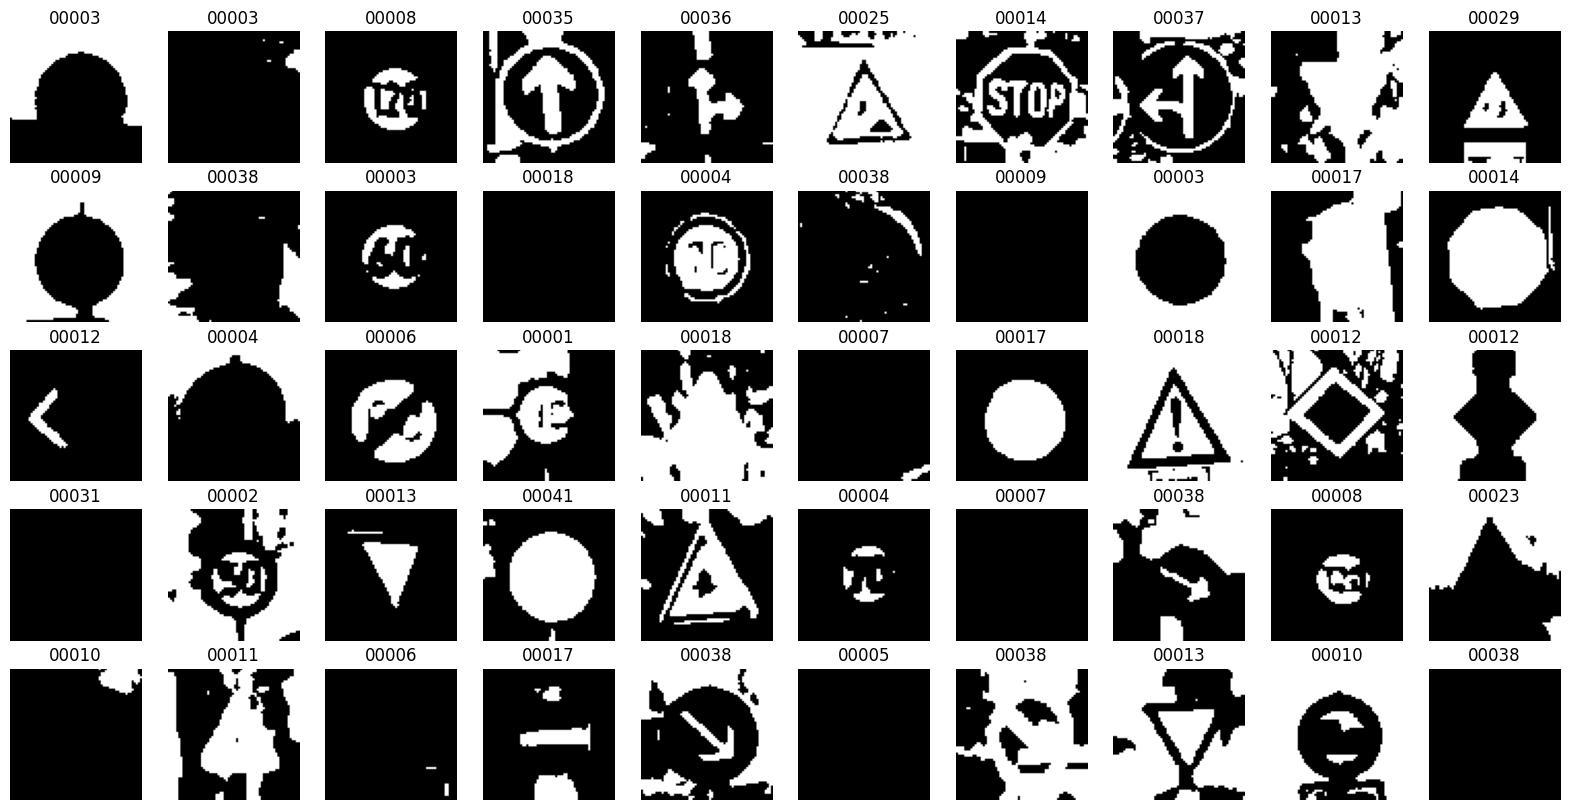

<Figure size 640x480 with 0 Axes>

In [48]:
# Supondo que a transformação ThresholdTransform esteja definida corretamente como:
class ThresholdTransform:
    def __init__(self, threshold):
        self.threshold = threshold

    def __call__(self, img):
        img = transforms.Grayscale()(img)
        img_bin = torch.where(img > self.threshold, torch.tensor(1.0), torch.tensor(0.0))
        return img_bin

threshold_transform = ThresholdTransform(threshold=0.35)

images_binarized = []
for image in train_images:
    image_binarized = threshold_transform(image)
    images_binarized.append(image_binarized)

# Converter a lista de imagens binarizadas para um tensor
images_binarized = torch.stack(images_binarized)

vcpi_util.show_images(5, 10, images_binarized, train_targets, train_set.classes)

----------------------------------------------------------------

In [ ]:
def readTrafficSigns(rootpath):
    images = []
    labels = []
    for c in range(0,43):
        prefix = rootpath + '/' + format(c, '05d') + '/'
        gtFile = open(prefix + 'GT-'+ format(c, '05d') + '.csv')
        gtReader = csv.reader(gtFile, delimiter=';')
        next(gtReader)  # Use next method to skip the header
        for row in gtReader:
            images.append(plt.imread(prefix + row[0]))
            labels.append(row[7])
        gtFile.close()
    return images, labels

39209 39209


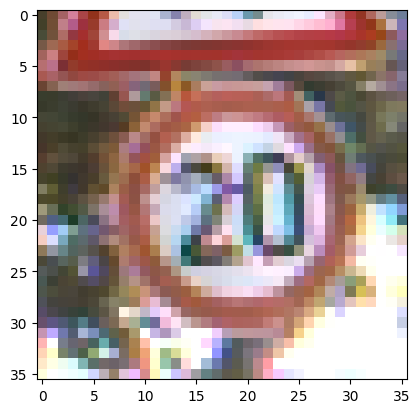

In [ ]:
# NAO CORRER ISTO PORQUE DEMORA HORAS!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
trainImages, trainLabels = readTrafficSigns(PATH_TRAINING_SET)
print (len(trainLabels), len(trainImages))
plt.imshow(trainImages[42])
plt.show()